# Exploring and Clustering Restaurants in Bangalore

### IBM Applied Data Science Capstone Course by Coursera

### Introduction

The objective of this project is to understand the type of restaurants and the options available to the tourist and the foodie in the Bangalore, India. We will attempt to cluster the restaurants based on the feedback(rating if available on the data) received.

### Interest

The outcome will be best suitable for starting new business and for the food explorer who really cannot explore food at the current situation. However, we can come to a conclusion at the end of the project.

### Data

We will attempt to use the FourSquare API as the primary data source to generate data. If required we will use Wikipedia




#### Required libraries are imported

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import random # library for random number generation

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported. We can now proceed with the rest of the project')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported. We can now proceed with the rest of the project


#### Define Foursquare Credentials and Version

In [2]:
# @hidden_cell
CLIENT_ID = 'XX' # your Foursquare ID
CLIENT_SECRET = 'XX' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 50

#### Using Geopy, the coordinates for Bangalore are located

In [3]:
address = 'Bangalore'

geolocator = Nominatim(user_agent="BLR_Explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Bangalore are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Bangalore are 12.9791198, 77.5912997.


In [16]:
LIMIT = 200
radius = 2000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=VULNWTQGV2CTJWJIALXDTV0LBY3TJAW1I22JJXW0ZLQ04132&client_secret=5QO5QLLYOXOHS3WTBTDUN4PMZ5BZ0EVS0RGJWLR3ZUGHBTEP&v=20180604&ll=12.9791198,77.5912997&radius=2000&limit=200'

In [17]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ec155133907e7001bce92f6'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Bangalore',
  'headerFullLocation': 'Bangalore',
  'headerLocationGranularity': 'city',
  'totalResults': 175,
  'suggestedBounds': {'ne': {'lat': 12.997119818000018,
    'lng': 77.60973715028112},
   'sw': {'lat': 12.961119781999981, 'lng': 77.57286224971887}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bbc4513e45295217db855a4',
       'name': 'Cubbon Park',
       'location': {'address': 'M G Road',
        'lat': 12.977042175203783,
        'lng': 77.59527683258057,
        'labeledLatLngs': [{'label': 'display',
          'lat': 12.977042175203783,
          'l

#### Define information of interest and filter dataframe

In [423]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Get relevant part of JSON and transform it into a pandas dataframe

In [424]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.id', 'venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.location.crossStreet']
nearby_venues = nearby_venues.loc[:, filtered_columns]

/home/valentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [425]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

In [426]:
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues = nearby_venues.reset_index(drop = True)
nearby_venues.head()

,id,name,categories,lat,lng,crossStreet
0,4bbc4513e45295217db855a4,Cubbon Park,Park,12.977042,77.595277,NaN
1,51d1245e498ef93fd0e713bb,JW Marriott Hotel Bengaluru,Hotel,12.972362,77.595051,NaN
2,4b69572ff964a520509f2be3,Taj West End,Hotel,12.984572,77.584893,NaN
3,4b7965c1f964a52085f72ee3,Infinitea,Tea Room,12.987157,77.594835,Vasanth Nagar
4,4b9f5637f964a5203f1d37e3,M. Chinnaswamy Stadium,Cricket Ground,12.978144,77.599223,NaN


#### Identify the unique values in column 'Categories'

In [427]:
nearby_venues['categories'].unique()

array(['Park', 'Hotel', 'Tea Room', 'Cricket Ground',
       'Italian Restaurant', 'Shopping Mall', 'French Restaurant',
       'Lounge', 'Japanese Restaurant', 'Asian Restaurant',
       'Indian Restaurant', 'Deli / Bodega', 'American Restaurant',
       'Cupcake Shop', 'Ice Cream Shop', 'Bakery', 'Clothing Store',
       'Furniture / Home Store', 'Racetrack', 'Burger Joint',
       'Breakfast Spot', 'Plaza', 'Brewery', 'Cocktail Bar',
       'Toy / Game Store', 'Sushi Restaurant', 'Steakhouse', 'Pub',
       'Bookstore', 'Afghan Restaurant', 'Seafood Restaurant',
       'Bubble Tea Shop', 'Golf Course', 'Fried Chicken Joint',
       'Hotel Bar', 'Art Gallery', 'Gym / Fitness Center',
       'Athletics & Sports', 'Café', 'Vietnamese Restaurant',
       'Concert Hall', 'Music Store', 'Pizza Place', 'Coffee Shop',
       'Art Museum', 'Bed & Breakfast', 'Nightclub', 'Arcade',
       'Chinese Restaurant', 'Wine Bar', 'Vegetarian / Vegan Restaurant',
       'Gym', 'Restaurant', 'South Ind

In [428]:
only_restaurants = nearby_venues

In [429]:
restarants_categories = ['Tea Room', 'Italian Restaurant', 'French Restaurant', 'Japanese Restaurant', 'Asian Restaurant',
       'Indian Restaurant', 'Deli / Bodega', 'American Restaurant', 'Cupcake Shop', 'Ice Cream Shop', 'Burger Joint', 'Breakfast Spot', 'Sushi Restaurant', 'Steakhouse', 'Afghan Restaurant', 'Seafood Restaurant',
       'Bubble Tea Shop', 'Fried Chicken Joint', 'Café', 'Vietnamese Restaurant', 'Pizza Place', 'Coffee Shop',
       'Bed & Breakfast', 'Chinese Restaurant', 'Vegetarian / Vegan Restaurant', 'Restaurant', 'South Indian Restaurant', 'Karnataka Restaurant']

In [430]:
only_restaurants.shape

(100, 6)

In [431]:
only_restaurants = only_restaurants.query('categories in @restarants_categories')

In [432]:
only_restaurants.shape

(55, 6)

In [433]:
only_restaurants.head()

,id,name,categories,lat,lng,crossStreet
3,4b7965c1f964a52085f72ee3,Infinitea,Tea Room,12.987157,77.594835,Vasanth Nagar
5,4bc1cd90b492d13a4e74a660,Toscano,Italian Restaurant,12.971980,77.596066,24 Vittal Mallya Road
7,4baef172f964a5202ce33be3,Café Noir,French Restaurant,12.971995,77.596001,at Vittal Mallya Rd
9,4b895510f964a520442c32e3,Shiro,Japanese Restaurant,12.971900,77.596236,Lavelle Rd.
10,523de40611d2996a150886fc,J W Kitchen,Asian Restaurant,12.972410,77.594592,Vittal Mallya Road


In [434]:
only_restaurants.reset_index(drop=True)

,id,name,categories,lat,lng,crossStreet
0,4b7965c1f964a52085f72ee3,Infinitea,Tea Room,12.987157,77.594835,Vasanth Nagar
1,4bc1cd90b492d13a4e74a660,Toscano,Italian Restaurant,12.971980,77.596066,24 Vittal Mallya Road
2,4baef172f964a5202ce33be3,Café Noir,French Restaurant,12.971995,77.596001,at Vittal Mallya Rd
3,4b895510f964a520442c32e3,Shiro,Japanese Restaurant,12.971900,77.596236,Lavelle Rd.
4,523de40611d2996a150886fc,J W Kitchen,Asian Restaurant,12.972410,77.594592,Vittal Mallya Road
5,4bc0849eb492d13ae253a460,Masala Klub,Indian Restaurant,12.984993,77.585115,NaN
6,520390f3498ebe0f1dd63e9e,Smoke House Deli,Deli / Bodega,12.971656,77.598254,Lavelle Road
7,4b5aaef9f964a520b8d028e3,Hard Rock Cafe Bengaluru,American Restaurant,12.976389,77.601468,St. Marks Rd
8,4c8b8c31a92fa093fe789bbf,Bliss Luxe Chocolate Lounge,Cupcake Shop,12.971525,77.596201,Vittal Mallya Road
9,4bfd513fe9309521040962ab,Corner House,Ice Cream Shop,12.972979,77.599971,Madras Bank Rd.


In [436]:
only_restaurants.dtypes

id              object
name            object
categories      object
lat            float64
lng            float64
crossStreet     object
dtype: object

In [477]:
# get likes from Foursquare API based on venue ID
url_list = []
likes_list = []
json_list = []

for i in restids:
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)
for link in url_list:
    result = requests.get(link).json()
    likes = result['response']['likes']['count']
    likes_list.append(likes)
print(likes_list)

[126, 127, 163, 140, 43, 16, 111, 483, 11, 59, 267, 230, 85, 54, 34, 48, 126, 4, 14, 99, 15, 17, 14, 11, 60, 5, 15, 56, 29, 39, 15, 37, 24, 29, 24, 10, 133, 29, 327, 23, 7, 13, 14, 13, 8, 17, 14, 10, 12, 38, 9, 13, 5, 36, 6]


In [437]:
restids = only_restaurants['id'].tolist()

In [478]:
blr_venues = only_restaurants.copy()
blr_venues

,id,name,categories,lat,lng,crossStreet
3,4b7965c1f964a52085f72ee3,Infinitea,Tea Room,12.987157,77.594835,Vasanth Nagar
5,4bc1cd90b492d13a4e74a660,Toscano,Italian Restaurant,12.971980,77.596066,24 Vittal Mallya Road
7,4baef172f964a5202ce33be3,Café Noir,French Restaurant,12.971995,77.596001,at Vittal Mallya Rd
9,4b895510f964a520442c32e3,Shiro,Japanese Restaurant,12.971900,77.596236,Lavelle Rd.
10,523de40611d2996a150886fc,J W Kitchen,Asian Restaurant,12.972410,77.594592,Vittal Mallya Road
11,4bc0849eb492d13ae253a460,Masala Klub,Indian Restaurant,12.984993,77.585115,NaN
12,520390f3498ebe0f1dd63e9e,Smoke House Deli,Deli / Bodega,12.971656,77.598254,Lavelle Road
14,4b5aaef9f964a520b8d028e3,Hard Rock Cafe Bengaluru,American Restaurant,12.976389,77.601468,St. Marks Rd
15,4c8b8c31a92fa093fe789bbf,Bliss Luxe Chocolate Lounge,Cupcake Shop,12.971525,77.596201,Vittal Mallya Road
16,4bfd513fe9309521040962ab,Corner House,Ice Cream Shop,12.972979,77.599971,Madras Bank Rd.


In [482]:
# create column for restaurant likes
blr_venues["likes"] = likes_list
blr_venues

,id,name,categories,lat,lng,crossStreet,likes
3,4b7965c1f964a52085f72ee3,Infinitea,Tea Room,12.987157,77.594835,Vasanth Nagar,126
5,4bc1cd90b492d13a4e74a660,Toscano,Italian Restaurant,12.971980,77.596066,24 Vittal Mallya Road,127
7,4baef172f964a5202ce33be3,Café Noir,French Restaurant,12.971995,77.596001,at Vittal Mallya Rd,163
9,4b895510f964a520442c32e3,Shiro,Japanese Restaurant,12.971900,77.596236,Lavelle Rd.,140
10,523de40611d2996a150886fc,J W Kitchen,Asian Restaurant,12.972410,77.594592,Vittal Mallya Road,43
11,4bc0849eb492d13ae253a460,Masala Klub,Indian Restaurant,12.984993,77.585115,NaN,16
12,520390f3498ebe0f1dd63e9e,Smoke House Deli,Deli / Bodega,12.971656,77.598254,Lavelle Road,111
14,4b5aaef9f964a520b8d028e3,Hard Rock Cafe Bengaluru,American Restaurant,12.976389,77.601468,St. Marks Rd,483
15,4c8b8c31a92fa093fe789bbf,Bliss Luxe Chocolate Lounge,Cupcake Shop,12.971525,77.596201,Vittal Mallya Road,11
16,4bfd513fe9309521040962ab,Corner House,Ice Cream Shop,12.972979,77.599971,Madras Bank Rd.,59


In [480]:
blr_venues.describe()

,lat,lng,likes
count,55.000000,55.000000,55.000000
mean,12.977075,77.594166,61.218182
std,0.009225,0.009114,89.373269
min,12.964579,77.577130,4.000000
25%,12.971391,77.585959,13.000000
50%,12.974412,77.596066,24.000000
75%,12.985159,77.600535,59.500000
max,12.994142,77.608322,483.000000


In [484]:
blr_venues.shape

(55, 7)

In [485]:
blr_venues['categories'].value_counts()

Indian Restaurant                14
Café                              4
Ice Cream Shop                    3
Japanese Restaurant               2
Seafood Restaurant                2
French Restaurant                 2
Asian Restaurant                  2
Chinese Restaurant                2
Breakfast Spot                    2
Burger Joint                      2
Italian Restaurant                2
Sushi Restaurant                  2
Karnataka Restaurant              1
Cupcake Shop                      1
Pizza Place                       1
Afghan Restaurant                 1
Bed & Breakfast                   1
American Restaurant               1
Fried Chicken Joint               1
South Indian Restaurant           1
Bubble Tea Shop                   1
Deli / Bodega                     1
Steakhouse                        1
Tea Room                          1
Vietnamese Restaurant             1
Restaurant                        1
Coffee Shop                       1
Vegetarian / Vegan Restauran

In [486]:
blr_venues.dtypes

id              object
name            object
categories      object
lat            float64
lng            float64
crossStreet     object
likes            int64
dtype: object

In [487]:
blr_data = blr_venues.copy()

In [490]:
blr_data.shape

(55, 7)

In [491]:
blr_data['lat'] = blr_data['lat'].astype(float)
blr_data['lng'] = blr_data['lng'].astype(float)

In [492]:
blr_data.reset_index()

,index,id,name,categories,lat,lng,crossStreet,likes
0,3,4b7965c1f964a52085f72ee3,Infinitea,Tea Room,12.987157,77.594835,Vasanth Nagar,126
1,5,4bc1cd90b492d13a4e74a660,Toscano,Italian Restaurant,12.971980,77.596066,24 Vittal Mallya Road,127
2,7,4baef172f964a5202ce33be3,Café Noir,French Restaurant,12.971995,77.596001,at Vittal Mallya Rd,163
3,9,4b895510f964a520442c32e3,Shiro,Japanese Restaurant,12.971900,77.596236,Lavelle Rd.,140
4,10,523de40611d2996a150886fc,J W Kitchen,Asian Restaurant,12.972410,77.594592,Vittal Mallya Road,43
5,11,4bc0849eb492d13ae253a460,Masala Klub,Indian Restaurant,12.984993,77.585115,NaN,16
6,12,520390f3498ebe0f1dd63e9e,Smoke House Deli,Deli / Bodega,12.971656,77.598254,Lavelle Road,111
7,14,4b5aaef9f964a520b8d028e3,Hard Rock Cafe Bengaluru,American Restaurant,12.976389,77.601468,St. Marks Rd,483
8,15,4c8b8c31a92fa093fe789bbf,Bliss Luxe Chocolate Lounge,Cupcake Shop,12.971525,77.596201,Vittal Mallya Road,11
9,16,4bfd513fe9309521040962ab,Corner House,Ice Cream Shop,12.972979,77.599971,Madras Bank Rd.,59


In [493]:
blr_data

,id,name,categories,lat,lng,crossStreet,likes
3,4b7965c1f964a52085f72ee3,Infinitea,Tea Room,12.987157,77.594835,Vasanth Nagar,126
5,4bc1cd90b492d13a4e74a660,Toscano,Italian Restaurant,12.971980,77.596066,24 Vittal Mallya Road,127
7,4baef172f964a5202ce33be3,Café Noir,French Restaurant,12.971995,77.596001,at Vittal Mallya Rd,163
9,4b895510f964a520442c32e3,Shiro,Japanese Restaurant,12.971900,77.596236,Lavelle Rd.,140
10,523de40611d2996a150886fc,J W Kitchen,Asian Restaurant,12.972410,77.594592,Vittal Mallya Road,43
11,4bc0849eb492d13ae253a460,Masala Klub,Indian Restaurant,12.984993,77.585115,NaN,16
12,520390f3498ebe0f1dd63e9e,Smoke House Deli,Deli / Bodega,12.971656,77.598254,Lavelle Road,111
14,4b5aaef9f964a520b8d028e3,Hard Rock Cafe Bengaluru,American Restaurant,12.976389,77.601468,St. Marks Rd,483
15,4c8b8c31a92fa093fe789bbf,Bliss Luxe Chocolate Lounge,Cupcake Shop,12.971525,77.596201,Vittal Mallya Road,11
16,4bfd513fe9309521040962ab,Corner House,Ice Cream Shop,12.972979,77.599971,Madras Bank Rd.,59


In [495]:
blr_data_clean = blr_data.copy()

In [496]:
blr_data_clean.shape

(55, 7)

### Upon further research on the dataframe, it was found that the below rows did not allow the data to be mapped

1. 4bebb117b3352d7fefc656d2
2. 554c87f9498e693538d01d1d

### The above listed ids will be deleted

In [497]:
blr_data_clean.drop( blr_data_clean[ blr_data_clean['id'] == '4bebb117b3352d7fefc656d2' ].index , inplace=True)

In [498]:
blr_data_clean.drop( blr_data_clean[ blr_data_clean['id'] == '554c87f9498e693538d01d1d' ].index , inplace=True)

In [499]:
blr_data_clean.shape

(53, 7)

In [500]:
blr_data_clean.reset_index()

,index,id,name,categories,lat,lng,crossStreet,likes
0,3,4b7965c1f964a52085f72ee3,Infinitea,Tea Room,12.987157,77.594835,Vasanth Nagar,126
1,5,4bc1cd90b492d13a4e74a660,Toscano,Italian Restaurant,12.971980,77.596066,24 Vittal Mallya Road,127
2,7,4baef172f964a5202ce33be3,Café Noir,French Restaurant,12.971995,77.596001,at Vittal Mallya Rd,163
3,9,4b895510f964a520442c32e3,Shiro,Japanese Restaurant,12.971900,77.596236,Lavelle Rd.,140
4,10,523de40611d2996a150886fc,J W Kitchen,Asian Restaurant,12.972410,77.594592,Vittal Mallya Road,43
5,11,4bc0849eb492d13ae253a460,Masala Klub,Indian Restaurant,12.984993,77.585115,NaN,16
6,12,520390f3498ebe0f1dd63e9e,Smoke House Deli,Deli / Bodega,12.971656,77.598254,Lavelle Road,111
7,14,4b5aaef9f964a520b8d028e3,Hard Rock Cafe Bengaluru,American Restaurant,12.976389,77.601468,St. Marks Rd,483
8,15,4c8b8c31a92fa093fe789bbf,Bliss Luxe Chocolate Lounge,Cupcake Shop,12.971525,77.596201,Vittal Mallya Road,11
9,16,4bfd513fe9309521040962ab,Corner House,Ice Cream Shop,12.972979,77.599971,Madras Bank Rd.,59


In [453]:
address = 'Bangalore'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
radius = 50000
print('The geograpical coordinates of Bangalore are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Bangalore are 12.9791198, 77.5912997.


### Let's visualize the restaurants on the data set from FourSquare

In [510]:
venues_map = folium.Map(location=[latitude, longitude], tiles='CartoDB positron', zoom_start= 15)
#tiles='CartoDB positron'
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='Blue',
    popup='Bangalore',
    fill = True,
    fill_color = 'Orange',
    fill_opacity = 1
).add_to(venues_map)

# add the markers for hospitals as black circle markers
for lat, lng, label in zip(blr_data_clean.lat, blr_data_clean.lng, blr_data_clean.name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='black',
        popup=label,
        fill = True,
        fill_color='black',
        fill_opacity=1
    ).add_to(venues_map)

# display map
venues_map

In [511]:
for_mapping = blr_data_clean['categories'].value_counts().reset_index()
for_mapping.columns = ['Type of Business', 'Counts']

In [512]:
for_mapping

,Type of Business,Counts
0,Indian Restaurant,14
1,Ice Cream Shop,3
2,Café,3
3,Japanese Restaurant,2
4,Seafood Restaurant,2
5,French Restaurant,2
6,Asian Restaurant,2
7,Chinese Restaurant,2
8,Breakfast Spot,2
9,Burger Joint,2


### As we can see that the most of the restaurants in Bangalore are categorized as 'Indian Restaurant'

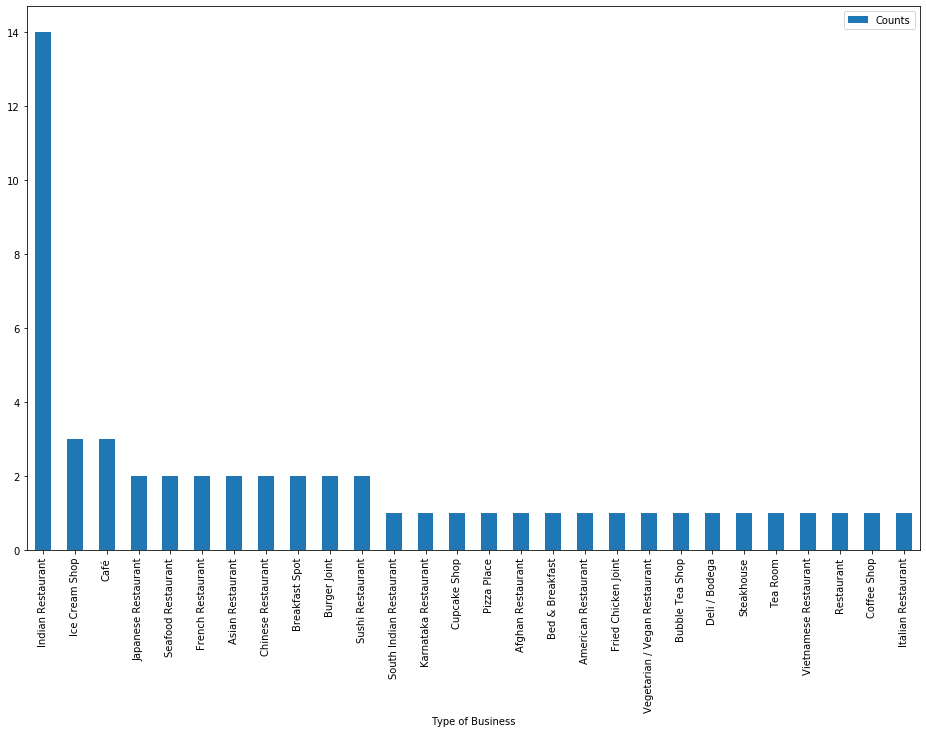

In [514]:
data=for_mapping[['Type of Business','Counts']]
data.set_index('Type of Business').plot(kind='bar',figsize=(16,10),tick_label=for_mapping['Type of Business'])

### Clustering based on the number of likes the restaurant has received

In [538]:
# one hot encoding
newdata_clus = pd.get_dummies(blr_data_clean[['name', 'likes']], prefix = "", prefix_sep = "")

# add neighborhood column back to dataframe
newdata_clus['name'] = blr_data_clean['name'] 

# move neighborhood column to the first column
fixed_columns = [newdata_clus.columns[-1]] + list(newdata_clus.columns[:-1])
newdata_clus = newdata_clus[fixed_columns]

newdata_clus.head()

,name,likes,Adarsh Hamilton,Airlines Hotel,Aromas Of South,Big Straw,Bliss Luxe Chocolate Lounge,Blue Ginger,Brik Oven,Café Noir,Chai Point,Chikkana Tiffin Room,Chowmein,Coast 2 Coast,Corner House,Desserted,Dum Pukht Jolly Nabobs,EDO,Fat Buddha,Hard Rock Cafe Bengaluru,Harima,Hotel Annapoorna,Hotel Fishland,Imperial Restaurant,Infinitea,J W Kitchen,Janardhan Hotel,Kabab Studio,Kazé,Kebabs & Kurries,Kentacky Chicken Corner,Konark Coffee Shop,Kudla,Lakshmi Nataraj Refreshments,MTR 1924,Mahesh Lunch Home,Masala Klub,Matteo,Millers 46,Natural Ice Cream,Oh Calcutta,Oko @ Lalit Ashok,Peppa Zzing,Samarkand,Shiro,Shiv Sagar,Smoke House Deli,Starbucks,Sunheri Restaurant,The Raj Pavilion,Toscano,Truffles - Ice & Spice,Ujwal Bar & Restaurant,Umesh Dosa Point
3,Infinitea,126,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Toscano,127,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,Café Noir,163,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Shiro,140,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
10,J W Kitchen,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [539]:
import matplotlib.pyplot as plt

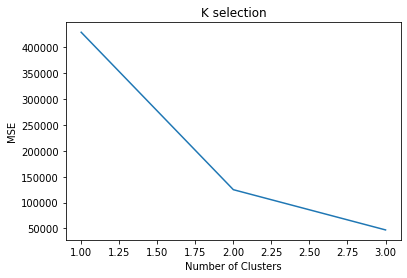

In [540]:
Ks = 4
mse = np.zeros((Ks - 1))
df_blr_cluster = newdata_clus.drop('name', axis = 1)
for n in range(1, Ks):
    
    # set number of clusters
    kclusters = n
    # run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(df_blr_cluster)
    mse[n - 1] = kmeans.inertia_

plt.plot(range(1,Ks), mse)
plt.xlabel("Number of Clusters")
plt.ylabel("MSE")
plt.title("K selection")
plt.show()

In [541]:
# run k-means clustering
k_clusters = 6
kmeans = KMeans(n_clusters = k_clusters, random_state = 0).fit(df_blr_cluster)
kmeans.labels_[0:10]

array([2, 2, 2, 2, 4, 0, 2, 3, 0, 4], dtype=int32)

In [542]:
# add cluster labels to main dataframe
blr_data_clean['cluster'] = kmeans.labels_
blr_data_clean

,id,name,categories,lat,lng,crossStreet,likes,cluster
3,4b7965c1f964a52085f72ee3,Infinitea,Tea Room,12.987157,77.594835,Vasanth Nagar,126,2
5,4bc1cd90b492d13a4e74a660,Toscano,Italian Restaurant,12.971980,77.596066,24 Vittal Mallya Road,127,2
7,4baef172f964a5202ce33be3,Café Noir,French Restaurant,12.971995,77.596001,at Vittal Mallya Rd,163,2
9,4b895510f964a520442c32e3,Shiro,Japanese Restaurant,12.971900,77.596236,Lavelle Rd.,140,2
10,523de40611d2996a150886fc,J W Kitchen,Asian Restaurant,12.972410,77.594592,Vittal Mallya Road,43,4
11,4bc0849eb492d13ae253a460,Masala Klub,Indian Restaurant,12.984993,77.585115,NaN,16,0
12,520390f3498ebe0f1dd63e9e,Smoke House Deli,Deli / Bodega,12.971656,77.598254,Lavelle Road,111,2
14,4b5aaef9f964a520b8d028e3,Hard Rock Cafe Bengaluru,American Restaurant,12.976389,77.601468,St. Marks Rd,483,3
15,4c8b8c31a92fa093fe789bbf,Bliss Luxe Chocolate Lounge,Cupcake Shop,12.971525,77.596201,Vittal Mallya Road,11,0
16,4bfd513fe9309521040962ab,Corner House,Ice Cream Shop,12.972979,77.599971,Madras Bank Rd.,59,4


### Visualization

In [543]:


map_clusters = folium.Map(location = [latitude, longitude], tiles='CartoDB positron', zoom_start = 14.5)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i + x + (i * x) ** 2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(blr_data_clean['lat'], blr_data_clean['lng'], blr_data_clean['name'], blr_data_clean['cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 7,
        popup = label,
        color = rainbow[cluster - 1],
        fill = True,
        fill_color = rainbow[cluster-1],
        fill_opacity = 0.7).add_to(map_clusters)
       
map_clusters

